<a href="https://colab.research.google.com/github/BaharehYekkehkhany/SAR-Vegetation-Index/blob/main/S1_2_NDVI_large_segments_11days_220119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## panda: load and store dataframe structures (tabular data)
import pandas as pd
## numpy: a numerical python library; to work with multi-dimentional arrays and mtrices
import numpy as np
## matplotlib: 2D and 3D plotting
import matplotlib.pyplot as plt
## sklearn: machine learning methods
## sklearn.linear_model.LinearRegression: provides linear regression function
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, LassoCV, Ridge
from sklearn.metrics import explained_variance_score, max_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
## Msklearn.neural_network.MLPRegressor: multi-layer Perceptron regressor
## This model optimizes the squared-loss using LBFGS or stochastic gradient descent.
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
# from sklearn import metrics
# import seaborn as sns
# # SVM classifier
# from sklearn.svm import SVC
# # to prepare data for SVM classification
# from sklearn.datasets.samples_generator import make_blobs
# from sklearn.datasets.samples_generator import make_circles
# from mpl_toolkits.mplot3d import Axes3D
## to load .mat files
from scipy.io import loadmat
from numpy import arange
import cmath
# ## to use HDF reader for matlab v7.3 files
# import h5py
import scipy
import scipy.io as spio

## https://www.youtube.com/watch?v=maiQf8ray_s
from scipy.stats import zscore
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation


##------------------------------------------------------------------------------
## change directory to google drive to read input and output data
##------------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')


##------------------------------------------------------------------------------
## import data
##------------------------------------------------------------------------------
## This function is a modified version of scipy.io.loadmat to read nested structures saved as .mat
## MATLAB reference: https://ch.mathworks.com/matlabcentral/answers/383427-proper-importing-of-matlab-structures-into-python
## Stack Overflow reference: https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def load_mat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

##------------------------------------------------------------------------------
def import_data():

  """
  import dataset: read 3 structures that include RS2 and RapidEye observations

  inputs:
  An structure that contains some Sentinel-1 parameters as well as NDVI obtained
  from Sentinel-2 observations with at most 5 days of acqusition difference in
  2019 for 6 days.

  All parameters extracted from S1 data will be predictor variables and the
  correspondence NDVI values are the desired outcomes to be estimated.

  outputs:
  dataset: a dictionary that includes all structure variables
  """

  dataset = load_mat('/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/S1_S2_DP_NDVI_large_segments_7days.mat')['S1_S2']
  # dataset = load_mat('/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/S1_S2_DP_NDVI_large_segments.mat')['S1_S2']

  # ## add radar vegetation index (RVI) to parameters
  # ## RVI is based on "https://trs.jpl.nasa.gov/bitstream/handle/2014/14473/00-0913.pdf?sequence=1"
  # dataset_2019['radar_vegetation_index'] = (8*np.array(dataset_2019['Backscatter_HV_Canola'])/ (np.array(dataset_2019['Backscatter_HH_Canola']) + np.array(dataset_2019['Backscatter_VV_Canola']) + 2*np.array(dataset_2019['Backscatter_HV_Canola']))).tolist()

  print('dataset.keys:')
  print(dataset.keys())

  ## convert dictionary to dataframe
  # dataset_2012 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dataset_2012.items() ]))

  ## replace +/- inf values with nan
  # dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
  # print(inputs.isna().sum())
  ## replace nan values with 0
  # dataset.fillna(0, inplace=True)

  return dataset


##------------------------------------------------------------------------------
## prepare input and output for regression
##------------------------------------------------------------------------------
def input_output_preparation(input, scaling, scaling_method):

  """
  Vectorize the datasets and separate them into input and output dataframes for
  the NDVI estimation process

  input:
  dataset: a dictionary that includes all variables

  output:
  inputs_vectored: a dataframe that includes all predictor variables
  outputs_vectored: a dataframe that includes all correspondence intepolated NDVI values
  """

  ## vectorize dataset
  n_fields, n_days = np.shape(input['NDVI_S2'])
  # print(f"\n number of fields: {n_fields}, number of days: {n_days}, whole number of sample data: {n_fields*n_days}")
  input = pd.DataFrame.from_dict(input)

  input_vector = []
  input_vectored = pd.DataFrame()
  for key in input.keys():
    input_vector = []
    for field in range(n_fields):
      for day in range(n_days):
        input_vector.append(input[key][field][day])
    temp = pd.DataFrame(input_vector, columns=[key], dtype='float64')
    temp.reset_index(drop=True, inplace=True)
    input_vectored = pd.concat([input_vectored , temp], axis=1)

  data_vectored_with_invalid_NDVIs = input_vectored.copy()
  ## remove NaN values
  input_vectored.dropna(axis=0, how='any', inplace=True)
  ## remove rows with NDVI_S2 = 0
  input_vectored = input_vectored[input_vectored.NDVI_S2 != 0]
  ## remove rows with NDVI_S2 < 0 (remove negative NDVI values)
  input_vectored = input_vectored[input_vectored.NDVI_S2 > 0]
  ## remove rows with NDVI_S2 > 1
  input_vectored = input_vectored[input_vectored.NDVI_S2 < 1]

  ## separate input and output dataframe
  output_vectored = pd.DataFrame({'NDVI_S2': \
                                  input_vectored['NDVI_S2']})
  input_vectored.drop(['NDVI_S2'], axis=1, inplace=True)
  input_vectored.drop(['alpha1_Canola_2019'], axis=1, inplace=True)
  input_vectored.drop(['alpha2_Canola_2019'], axis=1, inplace=True)

  ## generate input and output with invalid NDVI values
  ## these are created so that at the end, all samples can be sorted based on
  ## their field number and day number
  output_vectored_with_invalid_NDVIs = pd.DataFrame({'NDVI_S2': \
                                  data_vectored_with_invalid_NDVIs['NDVI_S2']})
  data_vectored_with_invalid_NDVIs.drop(['NDVI_S2'], axis=1, inplace=True)
  data_vectored_with_invalid_NDVIs.drop(['alpha1_Canola_2019'], axis=1, inplace=True)
  data_vectored_with_invalid_NDVIs.drop(['alpha2_Canola_2019'], axis=1, inplace=True)
  input_vectored_with_invalid_NDVIs = data_vectored_with_invalid_NDVIs.copy()

  n_samples = np.shape(output_vectored['NDVI_S2'])
  print(f"\n number of fields: {n_fields}, number of days: {n_days}, whole number of sample data: {n_samples}")

  ## normalize input and output data
  if scaling == 1:
    if scaling_method == 'min_max':
      ## min-max normalization:
      input = (input_vectored - input_vectored.min())/( \
                    input_vectored.max() - input_vectored.min())
      input_vectored_with_invalid_NDVIs = \
        (input_vectored_with_invalid_NDVIs - input_vectored_with_invalid_NDVIs.min())/( \
          input_vectored_with_invalid_NDVIs.max() - input_vectored_with_invalid_NDVIs.min())
    elif scaling_method == 'mean_std':
      ## mean_std standardization
      input = (input_vectored - input_vectored.mean())/input_vectored.std()
      input_vectored_with_invalid_NDVIs = (input_vectored_with_invalid_NDVIs - \
        input_vectored_with_invalid_NDVIs.mean())/input_vectored_with_invalid_NDVIs.std()
  else:
    input = input_vectored.copy()

  output = output_vectored.copy()

  return input, output, input_vectored_with_invalid_NDVIs, \
    output_vectored_with_invalid_NDVIs, n_days, n_fields


##------------------------------------------------------------------------------
## predictor variable selection
##------------------------------------------------------------------------------
def predictor_selection(inputs, outputs, input_vectored_with_invalid_NDVIs, \
                        alpha, selection_criteria, model_name):

  if model_name.lower() in ['lasso']:
    ## Lasso(alpha=1.0, *, fit_intercept=True, normalize=True,\
    ##  precompute=False, copy_X=True, max_iter=1000, tol=0.0001, \
    ##  warm_start=False, positive=False, random_state=None, selection='cyclic')
    model = Lasso(alpha=alpha)
    model.fit(inputs.values, outputs)
  elif model_name.lower() in ['ridge']:
    ## Ridge(alpha=1.0, *, fit_intercept=True, normalize=False, copy_X=True, \
    ##  max_iter=None, tol=0.001, solver='auto', random_state=None)
    model = Ridge(alpha=alpha)
    model.fit(inputs.values, outputs)

  selected_columns = abs(model.coef_) > selection_criteria
  if np.any(selected_columns):
    selected_inputs = inputs.loc[:, np.transpose(selected_columns)]
    selected_input_vectored_with_invalid_NDVIs = \
        input_vectored_with_invalid_NDVIs.loc[:, np.transpose(selected_columns)]
  else:
    selected_columns = abs(model.coef_) == max(abs(model.coef_))
    selected_inputs = inputs.loc[:, selected_columns]
    selected_input_vectored_with_invalid_NDVIs = \
        input_vectored_with_invalid_NDVIs.loc[:, selected_columns]
  print('\nselected input features')
  print(selected_inputs.keys())
  print('\n input coefficients after feature selection:')
  print(model.coef_)

  # model = Lasso(alpha=alpha)
  # # model.fit(inputs.iloc[0,:].values, outputs.iloc[0,:].values)
  # # model.fit(inputs.values, outputs.values)
  # model.fit(inputs.values.real, outputs)
  # selected_columns = model.coef_ > selection_criteria
  # selected_inputs = inputs.loc[:, selected_columns]
  # print('selected_inputs.keys')
  # print(selected_inputs.keys())
  # print(model.coef_)

  return selected_inputs, selected_input_vectored_with_invalid_NDVIs, selected_columns


##------------------------------------------------------------------------------
## regression models
##------------------------------------------------------------------------------
## MLP regression
def mlp_regression(input, output, selected_input_vectored_with_invalid_NDVIs, \
                   activation, solver, alpha, batch_size, max_iter, k_fold):

## neural network multi-layer Perceptron (NN-MLP) regressor
## This model optimizes the squared-loss using LBFGS or stochastic gradient descent.
## evaluate the model predictions using the test data

## input:
## x_train, y_train: train data
## x_test, y_test: test data
## max_iter: maximum iteration of the MLP regressor

## output:
  # model = MLPRegressor(max_iter, batch_size=min(batch_size, x_train.shape[0]), \
  #                       random_state=1)

  x = input.values
  y = output.values

  ## cross validation iterators
  ## K-fold
  from sklearn.model_selection import KFold
  kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
  cvi = kf
  ## repeated K-fold
  # from sklearn.model_selection import RepeatedKFold
  # rkf = RepeatedKFold(n_splits=k_fold, n_repeats=3, random_state=42)
  # cvi = rkf
  ## leave one out
  # from sklearn.model_selection import LeaveOneOut
  # loo = LeaveOneOut()
  # cvi = loo
  ## leave P out
  # from sklearn.model_selection import LeavePOut
  # lpo = LeavePOut(p=2)
  # cvi = lpo
  ## Random permutations cross-validation a.k.a. Shuffle & Split
  # from sklearn.model_selection import ShuffleSplit
  # ss = ShuffleSplit(n_splits=k_fold, test_size=0.2, random_state=1)
  # cvi = ss


  oos_y = []
  oos_pred = []

  rmse = 1
  fold = 0
  for train, test in cvi.split(x):
    fold+=1
    print(f"Fold #{fold}")

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]

    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation=activation))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=solver)

    # model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=max_iter)
    model.fit(x_train, y_train, validation_split=0.2, verbose=0, epochs=100)

    pred = model.predict(x_test)

    ## out of sample: oos
    oos_y.append(y_test)
    oos_pred.append(pred)

    ## measure this fold's rmse
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"Fold rmse: {score:5.3f}")
    print(f"Fold mean absolute error: {mean_absolute_error(y_test, pred):5.3f}")
    print(f"Fold r2: {r2_score(y_test, pred):5.3f}")
    cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
    print(f"Fold correlation coefficient: {cc[0, 1]:5.3f}")

    out_predict = model.predict(x)
    plt.scatter(out_predict, y, color="blue")
    plt.xlabel("predicted NDVI by neural networks")
    plt.ylabel("NDVI measured by Sentinel-2")
    plt.title("neural networks regression")
    plt.show()

    ## find the best model and predict the output (NDVI) for all the input data
    ## with the best model
    if score < rmse:
      rmse = score
      output_predicted_vectored_with_invalid_NDVIs = \
          model.predict(selected_input_vectored_with_invalid_NDVIs)
      output_predict = model.predict(input)
      best_x_train = x_train
      best_y_train = y_train
      best_x_test = x_test
      best_y_test = y_test

      best_model = model

      best_rmse = score
      best_r2 = r2_score(y_test, pred)
      best_cc = cc[0, 1]
      best_mae = mean_absolute_error(y_test, pred)

      best_fold = fold

  ## Show the statistics for the best fold
  print(f"\n \nBest fold number: {best_fold}")
  print(f"Best model rmse: {best_rmse:5.3f}")
  print(f"Best model mae: {best_mae:5.3f}")
  print(f"Best model r2: {best_r2:5.3f}")
  print(f"Best model cc: {best_cc:5.3f}")

  ## plot NDVI interpolated data vs NDVI predicted data
  plt.scatter(output_predict, y, color="blue")
  plt.xlabel("predicted NDVI by NN model")
  plt.ylabel("NDVI measured by Sentinel-2")
  plt.title("NN regression")
  plt.show()

  ## polts color-filtered by wind speed values
  ## train and test separated
  print('train size:')
  print(np.shape(best_y_train))
  print('test size:')
  print(np.shape(best_y_test))
  print('\n')
  plt.title('NN regression')
  plt.scatter(best_model.predict(best_x_train), best_y_train, label="train data")
  plt.scatter(best_model.predict(best_x_test), best_y_test, label="test data")
  plt.xlabel("predicted NDVI by NN model")
  plt.ylabel("NDVI measured by Sentinel-2")
  plt.legend()
  plt.show()

  ## out of sample (OOS)
  ## build the oos prediction list and calculate error
  oos_y = np.concatenate(oos_y)
  oos_pred = np.concatenate(oos_pred)
  score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
  print(f"\n \nFinal, out of sample rmse: {score:5.3f}")
  print(f"Final, out of sample r2: {r2_score(oos_y, oos_pred):5.3f}")
  corre_coef = np.corrcoef(np.transpose(oos_pred), \
              np.transpose(oos_y))
  print(f"Final, out of sample cc: {corre_coef[0, 1]:5.3f}")
  print(f"Final, out of sample mae: {mean_absolute_error(oos_y, oos_pred):5.3f}")
  # print(f"Final, out of sample maximum residual error: {max_error(oos_y, oos_pred)}")

  ## convert the out of sample dataset to DataFrame
  oos_y = pd.DataFrame(oos_y)
  oos_pred = pd.DataFrame(oos_pred)
  oosDF = pd.concat([oos_y, oos_pred], axis=1)
  # oosDF.to_csv(filename_write, index=False)

  ## plot out of sample NDVI interpolated data vs NDVI predicted data
  plt.scatter(oos_pred, oos_y, color="blue")
  plt.xlabel("out of sample predicted NDVI by NN")
  plt.ylabel("out of sample NDVI measured by Sentinel-2")
  plt.title("NN regression")
  plt.show()

  return output_predicted_vectored_with_invalid_NDVIs, best_model


##------------------------------------------------------------------------------
## Random forest (RF) regression
def random_forest_regression(input, output, \
                             selected_input_vectored_with_invalid_NDVIs, k_fold):

  ## input:
  ## input: all parameters extracted from pol-SAR data as predictors
  ## output: the target which is the NDVI values based on RapiEye observations
  ## k_fold: number of subsections defined in cross validation

  ## output:
  ## output_predict: predicted NDVI values

  x = input.values
  y = output.values

  ## cross validation iterators
  ## K-fold
  from sklearn.model_selection import KFold
  kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
  cvi = kf
  ## repeated K-fold
  # from sklearn.model_selection import RepeatedKFold
  # rkf = RepeatedKFold(n_splits=k_fold, n_repeats=3, random_state=42)
  # cvi = rkf
  ## leave one out
  # from sklearn.model_selection import LeaveOneOut
  # loo = LeaveOneOut()
  # cvi = loo
  ## leave P out
  # from sklearn.model_selection import LeavePOut
  # lpo = LeavePOut(p=2)
  # cvi = lpo
  ## Random permutations cross-validation a.k.a. Shuffle & Split
  # from sklearn.model_selection import ShuffleSplit
  # ss = ShuffleSplit(n_splits=k_fold, test_size=0.2, random_state=1)
  # cvi = ss


  oos_y = []
  oos_pred = []

  rmse = 1
  fold = 0
  for train, test in cvi.split(x):
    fold+=1
    print(f"Fold #{fold}")

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]

    # define the model
    model = RandomForestRegressor()

    model.fit(x_train, y_train.ravel())

    pred = model.predict(x_test)

    ## out of sample: oos
    oos_y.append(y_test)
    oos_pred.append(pred)

    ## measure this fold's rmse
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"Fold rmse: {score:5.3f}")
    print(f"Fold mean absolute error: {mean_absolute_error(y_test, pred):5.3f}")
    print(f"Fold r2: {r2_score(y_test, pred):5.3f}")
    cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
    print(f"Fold correlation coefficient: {cc[0, 1]:5.3f}")

    out_predict = model.predict(x)
    plt.scatter(out_predict, y, color="blue")
    plt.xlabel("predicted NDVI by random forests")
    plt.ylabel("NDVI measured by Sentinel-2")
    plt.title("random forests regression")
    plt.show()

    ## find the best model and predict the output (NDVI) for all the input data
    ## with the best model
    if score < rmse:
      rmse = score
      output_predicted_vectored_with_invalid_NDVIs = \
          model.predict(selected_input_vectored_with_invalid_NDVIs)
      output_predict = model.predict(input)
      best_x_train = x_train
      best_y_train = y_train
      best_x_test = x_test
      best_y_test = y_test

      best_model = model

      best_rmse = score
      best_r2 = r2_score(y_test, pred)
      best_cc = cc[0, 1]
      best_mae = mean_absolute_error(y_test, pred)

      best_fold = fold

  ## Show the statistics for the best fold
  print(f"\n \nBest fold number: {best_fold}")
  print(f"Best model rmse: {best_rmse:5.3f}")
  print(f"Best model mae: {best_mae:5.3f}")
  print(f"Best model r2: {best_r2:5.3f}")
  print(f"Best model cc: {best_cc:5.3f}")

  ## plot NDVI interpolated data vs NDVI predicted data
  plt.scatter(output_predict, y, color="blue")
  plt.xlabel("predicted NDVI by RF model")
  plt.ylabel("NDVI measured by Sentinel-2")
  plt.title("RF regression")
  plt.show()

  ## polts color-filtered by wind speed values
  ## train and test separated
  print('train size:')
  print(np.shape(best_y_train))
  print('test size:')
  print(np.shape(best_y_test))
  print('\n')
  plt.title('RF regression')
  plt.scatter(best_model.predict(best_x_train), best_y_train, label="train data")
  plt.scatter(best_model.predict(best_x_test), best_y_test, label="test data")
  plt.xlabel("predicted NDVI by RF model")
  plt.ylabel("NDVI measured by Sentinel-2")
  plt.legend()
  plt.show()

  ## plot feature importance based on mean decrease in impurity
  ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
  feature_names = input.keys()
  importances = best_model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in best_model.estimators_], \
                axis=0)
  forest_importances = pd.DataFrame({'importances':importances, 'std':std}, \
                                    index=feature_names)
  ## sort features based on their importance
  forest_importances.sort_values(by=['importances'], ascending=False, \
                                  inplace=True)
  fig, ax = plt.subplots()
  forest_importances[\
      'importances'][0:10].plot.bar(yerr=forest_importances['std'][0:10], \
                                    ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()
  print("\n \n")

  ## plot feature importance based on feature permutation
  ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
  from sklearn.inspection import permutation_importance
  result = permutation_importance(best_model, best_x_test, best_y_test, \
      n_repeats=10, random_state=42, n_jobs=2)
  forest_importances = pd.DataFrame({'importances':result.importances_mean, \
      'std':result.importances_std}, index=feature_names)
  ## sort features based on their importance
  forest_importances.sort_values(by=['importances'], ascending=False, \
                                  inplace=True)
  fig, ax = plt.subplots()
  forest_importances[\
      'importances'][0:10].plot.bar(yerr=forest_importances['std'][0:10], ax=ax)
  ax.set_title("Feature importances using permutation on full model")
  ax.set_ylabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.show()

  ## out of sample (OOS)
  ## build the oos prediction list and calculate error
  oos_y = np.concatenate(oos_y)
  oos_pred = np.concatenate(oos_pred)
  score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
  print(f"\n \nFinal, out of sample rmse: {score:5.3f}")
  print(f"Final, out of sample r2: {r2_score(oos_y, oos_pred):5.3f}")
  corre_coef = np.corrcoef(np.transpose(oos_pred), \
              np.transpose(oos_y))
  print(f"Final, out of sample cc: {corre_coef[0, 1]:5.3f}")
  print(f"Final, out of sample mae: {mean_absolute_error(oos_y, oos_pred):5.3f}")
  # print(f"Final, out of sample maximum residual error: {max_error(oos_y, oos_pred)}")

  ## convert the out of sample dataset to DataFrame
  oos_y = pd.DataFrame(oos_y)
  oos_pred = pd.DataFrame(oos_pred)
  oosDF = pd.concat([oos_y, oos_pred], axis=1)
  # oosDF.to_csv(filename_write, index=False)

  ## plot out of sample NDVI interpolated measured by RapidEye vs NDVI predicted
  plt.scatter(oos_pred, oos_y, color="blue")
  plt.xlabel("out of sample predicted NDVI by random forests")
  plt.ylabel("out of sample NDVI measured by Sentinel-2")
  plt.title("random forests regression")
  plt.show()

  return output_predicted_vectored_with_invalid_NDVIs, best_model


##------------------------------------------------------------------------------
## remove invalid data with |NDVI|>1
def remove_invalid_predicted_values(y_test_predict, \
  y_test, y_train_predict, y_train):
  y_test_predict = pd.DataFrame(data=y_test_predict, columns=['NDVI_interpolated'])
  y_test_predict.reset_index(drop=True, inplace=True)
  y_test.reset_index(drop=True, inplace=True)
  # invalid_indexes = y_test_predict['NDVI_interpolated'] < 0
  invalid_indexes = abs(y_test_predict['NDVI_interpolated']) > 1

  y_test_predict.drop(y_test_predict[invalid_indexes].index, inplace=True)
  y_test.drop(y_test[invalid_indexes].index, inplace=True)

  y_train_predict = pd.DataFrame(data=y_train_predict, columns=['NDVI_interpolated'])
  y_train_predict.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)
  invalid_indexes = abs(y_train_predict['NDVI_interpolated']) > 1#< 0

  y_train_predict.drop(y_train_predict[invalid_indexes].index, inplace=True)
  y_train.drop(y_train[invalid_indexes].index, inplace=True)

  return y_test_predict, y_test, y_train_predict, y_train



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


dataset.keys:
dict_keys(['C11_Canola_2019', 'C22_Canola_2019', 'DoLP_Canola_2019', 'Lpr_Canola_2019', 'Phi_Canola_2019', 'Span_Canola_2019', 'Tau_Canola_2019', 'alpha1_Canola_2019', 'alpha2_Canola_2019', 'alpha_Canola_2019', 'anisotropy_Canola_2019', 'entropy_Canola_2019', 'entropy_sh_Canola_2019', 'entropy_sh_norm_Canola_2019', 'g0_Canola_2019', 'g1_Canola_2019', 'g2_Canola_2019', 'g3_Canola_2019', 'l1_Canola_2019', 'l2_Canola_2019', 'NDVI_S2'])

 number of fields: 321, number of days: 7, whole number of sample data: (1928,)
correlation coefiicient between RS2 SAR parameters and RapidEye NDVI: 
[['C11_Canola_2019', 0.5912683023488245], ['C22_Canola_2019', 0.7153607354178172], ['DoLP_Canola_2019', -0.6611171218731622], ['Lpr_Canola_2019', 0.6646267753644739], ['Phi_Canola_2019', 0.11121596474192598], ['Span_Canola_2019', 0.6385724091848383], ['Tau_Canola_2019', 0.04839198911813354], ['alpha_Canola_2019', 0.6576492981909859], ['anisotropy_Canola_2019', -0.6604606168896192], ['entropy_Ca

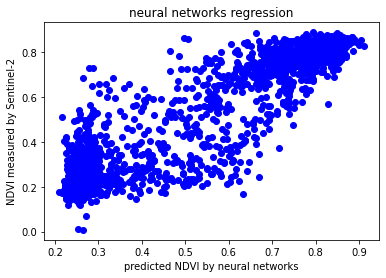

Fold #2
Fold rmse: 0.118
Fold mean absolute error: 0.087
Fold r2: 0.788
Fold correlation coefficient: 0.888


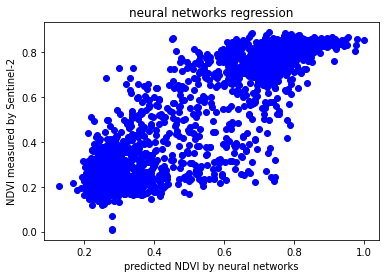

Fold #3
Fold rmse: 0.137
Fold mean absolute error: 0.098
Fold r2: 0.702
Fold correlation coefficient: 0.844


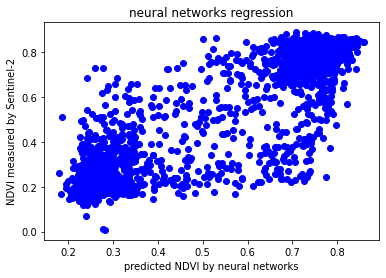

Fold #4
Fold rmse: 0.113
Fold mean absolute error: 0.081
Fold r2: 0.817
Fold correlation coefficient: 0.907


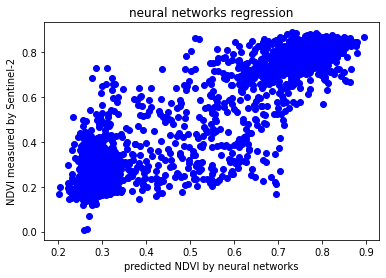

Fold #5
Fold rmse: 0.106
Fold mean absolute error: 0.074
Fold r2: 0.836
Fold correlation coefficient: 0.915


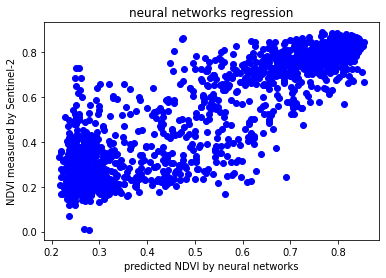

Fold #6
Fold rmse: 0.129
Fold mean absolute error: 0.096
Fold r2: 0.742
Fold correlation coefficient: 0.865


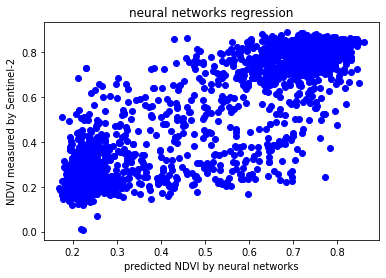

Fold #7
Fold rmse: 0.117
Fold mean absolute error: 0.080
Fold r2: 0.795
Fold correlation coefficient: 0.895


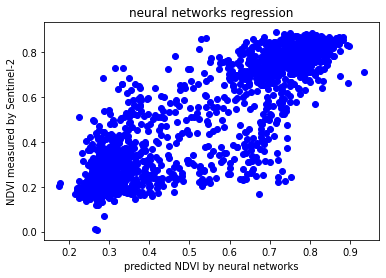

Fold #8
Fold rmse: 0.110
Fold mean absolute error: 0.088
Fold r2: 0.824
Fold correlation coefficient: 0.917


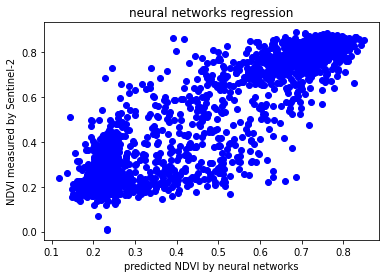

Fold #9
Fold rmse: 0.102
Fold mean absolute error: 0.073
Fold r2: 0.838
Fold correlation coefficient: 0.916


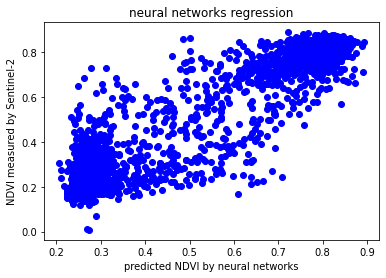

Fold #10
Fold rmse: 0.113
Fold mean absolute error: 0.078
Fold r2: 0.809
Fold correlation coefficient: 0.900


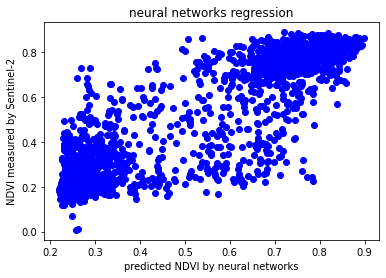


 
Best fold number: 1
Best model rmse: 0.098
Best model mae: 0.066
Best model r2: 0.859
Best model cc: 0.929


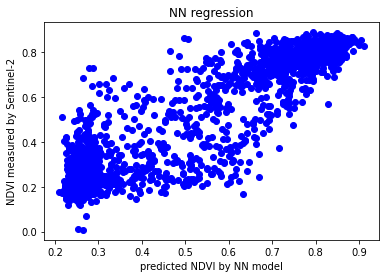

train size:
(1735, 1)
test size:
(193, 1)




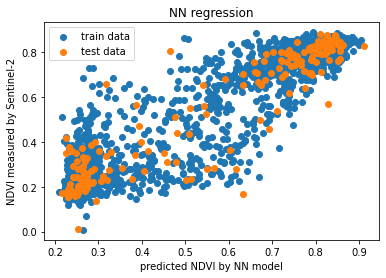


 
Final, out of sample rmse: 0.115
Final, out of sample r2: 0.803
Final, out of sample cc: 0.896
Final, out of sample mae: 0.082


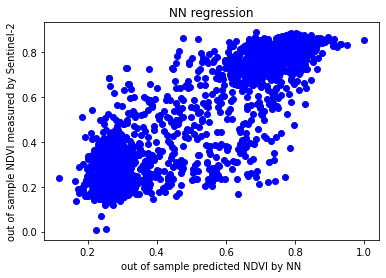

***** Random Forests *****
Fold #1
Fold rmse: 0.085
Fold mean absolute error: 0.056
Fold r2: 0.895
Fold correlation coefficient: 0.947


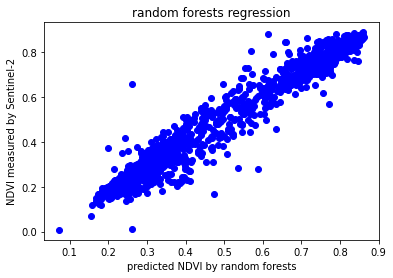

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Fold #2
Fold rmse: 0.100
Fold mean absolute error: 0.064
Fold r2: 0.849
Fold correlation coefficient: 0.922


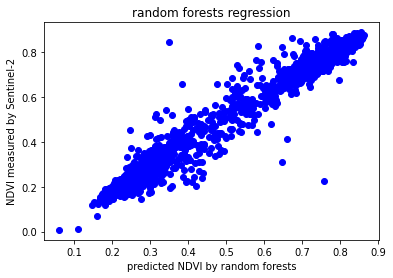

Fold #3
Fold rmse: 0.112
Fold mean absolute error: 0.075
Fold r2: 0.801
Fold correlation coefficient: 0.899


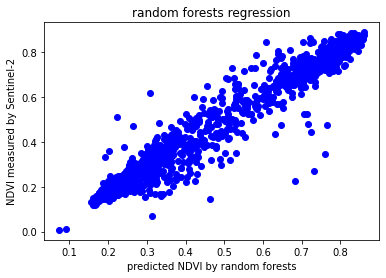

Fold #4
Fold rmse: 0.101
Fold mean absolute error: 0.066
Fold r2: 0.854
Fold correlation coefficient: 0.924


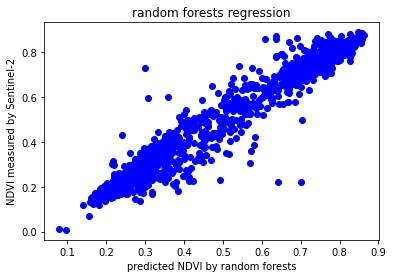

Fold #5
Fold rmse: 0.103
Fold mean absolute error: 0.070
Fold r2: 0.845
Fold correlation coefficient: 0.919


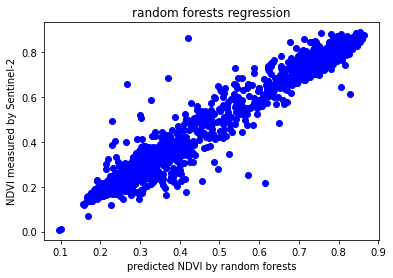

Fold #6
Fold rmse: 0.102
Fold mean absolute error: 0.071
Fold r2: 0.840
Fold correlation coefficient: 0.917


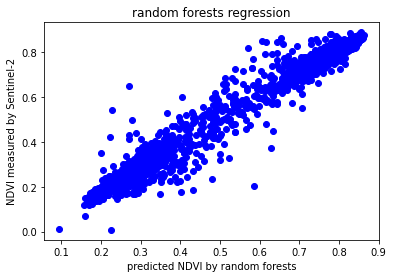

Fold #7
Fold rmse: 0.103
Fold mean absolute error: 0.067
Fold r2: 0.842
Fold correlation coefficient: 0.917


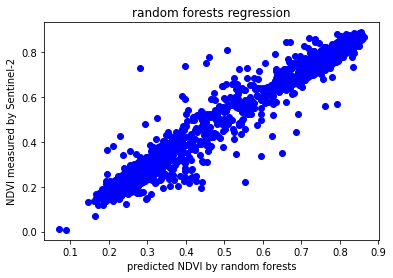

Fold #8
Fold rmse: 0.097
Fold mean absolute error: 0.065
Fold r2: 0.863
Fold correlation coefficient: 0.930


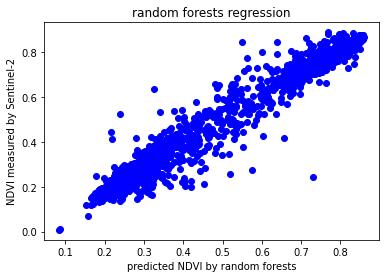

Fold #9
Fold rmse: 0.099
Fold mean absolute error: 0.068
Fold r2: 0.848
Fold correlation coefficient: 0.923


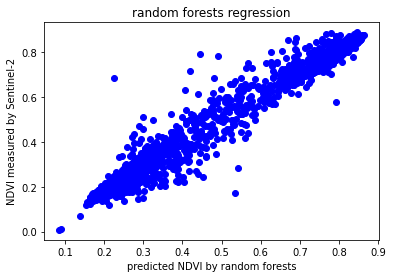

Fold #10
Fold rmse: 0.095
Fold mean absolute error: 0.065
Fold r2: 0.865
Fold correlation coefficient: 0.930


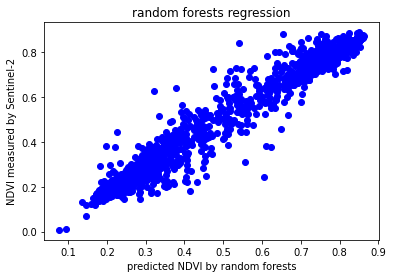


 
Best fold number: 1
Best model rmse: 0.085
Best model mae: 0.056
Best model r2: 0.895
Best model cc: 0.947


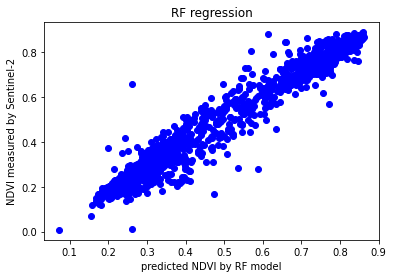

train size:
(1735, 1)
test size:
(193, 1)




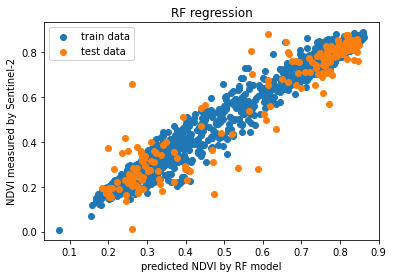

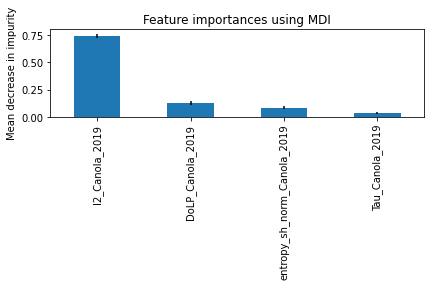

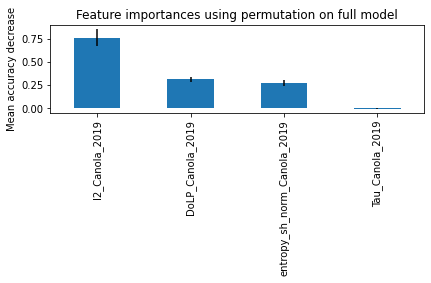


 
Final, out of sample rmse: 0.100
Final, out of sample r2: 0.851
Final, out of sample cc: 0.923
Final, out of sample mae: 0.067


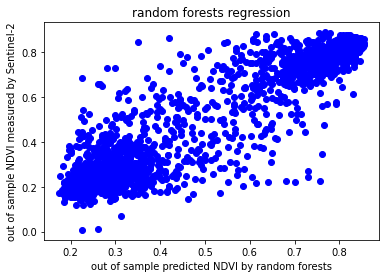

In [ ]:
repetition_number = 1
for repetition in range(repetition_number):


  ##------------------------------------------------------------------------------
  """
  There are three kinds of NDVIs:
  NDVI: measured by RapiEye observation
  NDVI_int: interpolated NDVI for RS2 acquisition times based on available NDVI values
    Here, interpolation is done by averaging the two nearest NDVI values to
    RS2 observations based on the acquisition times.
  NDVI_predicted: predicted NDVI values obtained from SAR data
  """

  dataset  = import_data()

  # dataset_2012, dataset_2016 = NDVI_interpolation(dataset_2012, dataset_2016, dataset_2019)

  ## Vectorize data
  ## generate separated input and output dataframe;
  ## normalize data if normalization is set to 1
  ## normalization methods: 'min_max', 'mean_std'
  inputs, outputs, input_vectored_with_invalid_NDVIs, \
    output_vectored_with_invalid_NDVIs, n_days, n_fields = \
      input_output_preparation(dataset, scaling=1, scaling_method='min_max')


  # inputs, outputs, data_vectored_with_invalid_NDVIs, n_days, n_fields = \
  #     input_output_preparation(dataset, scaling=1, scaling_method='min_max')

  # ## generate input and output with invalid NDVI values
  # ## these are created so that at the end, all samples can be sorted based on
  # ## their field number and day number
  # output_vectored_with_invalid_NDVIs = pd.DataFrame({'NDVI_S2': \
  #                                 data_vectored_with_invalid_NDVIs['NDVI_S2']})
  # data_vectored_with_invalid_NDVIs.drop(['NDVI_S2'], axis=1, inplace=True)
  # input_vectored_with_invalid_NDVIs = data_vectored_with_invalid_NDVIs.copy()



  # ## remove invalid data with values of abs(NDVI) > 1
  # invalid_indexes = outputs.loc[np.abs(abs(outputs['NDVI_interpolated']).astype(np.int8)) > 1]
  # if invalid_indexes['NDVI_interpolated'].any:
  #   inputs.drop(invalid_indexes['NDVI_interpolated'], inplace=True)

  ##------------------------------------------------------------------------------
  ## correlation coefiicient between RS2 SAR parameters and RapidEye NDVI
  ##------------------------------------------------------------------------------
  corre_coefs = []
  for field in inputs.keys():
    corre_coef = np.corrcoef(np.transpose(inputs[field]).astype(float), \
            np.transpose(outputs.values).astype(float))
    corre_coefs.append([field, corre_coef[0, 1]])
  print('correlation coefiicient between RS2 SAR parameters and RapidEye NDVI: ')
  print(corre_coefs)

  ##------------------------------------------------------------------------------
  ## feature selection: select predictor variables
  ##------------------------------------------------------------------------------
  ## model_name = 'Lasso' or 'Ridge'
  ## here, Lasso works well with alpha=0.02
  # selected_inputs = predictor_selection(inputs, outputs, alpha=0.02, \
  #   selection_criteria=1, model_name='lasso') # alpha=0.02
  selected_inputs, selected_input_vectored_with_invalid_NDVIs, selected_columns = \
      predictor_selection(inputs, outputs, \
                    input_vectored_with_invalid_NDVIs, alpha=0.001, \
                    selection_criteria=0.01, model_name='lasso') # alpha=0.02
  # selected_inputs = inputs.copy()


  # ## min_max normalization
  # inputs_normalized = (selected_inputs - selected_inputs.min())/( \
  #                   selected_inputs.max() - selected_inputs.min())
  # inputs_normalized = inputs.copy()
  inputs_normalized = selected_inputs.copy()
  outputs_normalized = outputs.copy()




  # print(np.corrcoef(inputs['Entropy_Canola'], inputs['Freeman_Volume_Canola']))
  # plt.scatter(inputs['Entropy_Canola'], inputs['Freeman_Volume_Canola'], color="blue")
  # plt.xlabel('Entropy_Canola')
  # plt.ylabel('Freeman_Volume_Canola')
  # plt.show()




  # ## plot interpolated NDVI vs selected predictor variables
  # for key in selected_inputs.keys():
  #   plt.scatter(selected_inputs[key], outputs_normalized, color="blue")
  #   # plt.scatter(x_test[:, i], y_test, color="red", label='test')
  #   plt.xlabel(key)
  #   plt.ylabel("NDVI_interpolated")
  #   # plt.legend()
  #   plt.show()

  # ##------------------------------------------------------------------------------
  # ## select training and test data
  # inputs_normalized = 100*inputs_normalized
  # outputs_normalized = 100*outputs_normalized
  # # x_train, x_test, y_train, y_test = test_train_selection(selected_inputs, outputs)
  # x_train, x_test, y_train, y_test = test_train_selection(inputs_normalized, outputs_normalized)
  # x_train = x_train/100
  # x_test = x_test/100
  # y_train = y_train/10000 # I devided NDVI by extra 100 as they should be between -1 and 1 and they have already been multiplied by 100 in the datasets
  # y_test = y_test/10000 # I devided NDVI by extra 100 as they should be between -1 and 1 and they have already been multiplied by 100 in the datasets

  # print("number of samples: {}, train data: {}, and test data: {} \n".format(\
  #   len(inputs), \
  #         len(x_train), len(x_test)))

  # print(x_train.shape)

  # ## plot interpolated NDVI vs selected predictor variables; train and test data are shown separated
  # i = 0
  # for key in selected_inputs.keys():
  #   print(i)
  #   plt.scatter(x_train[:, i], y_train, color="blue", label='train')
  #   plt.scatter(x_test[:, i], y_test, color="red", label='test')
  #   plt.xlabel(key)
  #   plt.ylabel("NDVI_interpolated")
  #   plt.legend()
  #   plt.show()
  #   i = i + 1

  ##----------------------------------------------------------------------------
  ## predict NDVI with regression models
  ##----------------------------------------------------------------------------
  # ## linear and polynomial regressions
  # ## k_fold = 20 gives the best results among 10, 20, and 30 in Polynomial regression
  # output_predict_poly = polynomial_regression(inputs_normalized, outputs_normalized, least_error = 100, k_fold=20)

  # # # ## remove invalid data with negative values of NDVI
  # # Y_test = y_test.copy() # to make sure that the main y_test and y_train dataframes are not changed
  # # Y_train = y_train.copy()
  # # y_test_predict_poly, y_test_poly, y_train_predict_poly, y_train_poly = \
  # #   remove_invalid_predicted_values(y_test_predict_poly, \
  # #   Y_test, y_train_predict_poly, Y_train)

  # ## plot NDVI test data vs NDVI predicted data
  # plt.scatter(output_predict_poly, outputs_normalized, color="blue")
  # plt.xlabel("predicted NDVI by Polynomial regression")
  # plt.ylabel("interpolated NDVI measured by RapidEye")
  # plt.title("polynomial regression")
  # plt.show()

  ##------------------------------------------------------------------------------
  ## neural network multi-layer Perceptron (NN-MLP) regressor

  """
  based on sklearn documentation on https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

  activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
  Activation function for the hidden layer.
  ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
  ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
  ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
  ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

  solver: {‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
  The solver for weight optimization.
  ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
  ‘sgd’ refers to stochastic gradient descent.
  ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
  Note: The default solver ‘adam’ works pretty well on relatively
  large datasets (with thousands of training samples or more) in terms of
  both training time and validation score. For small datasets, however,
  ‘lbfgs’ can converge faster and perform better.

  alpha: float, default=0.0001
  L2 penalty (regularization term) parameter.

  batch_size: int, default=’auto’
  Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’,
  the classifier will not use minibatch.
  When set to “auto”, batch_size=min(200, n_samples)
  """

  print('***** Neural Network *****')
  # ## k_fold = 10 gives the best results among 10, 20, and 30 in MLP regression
  output_predict_mlp, model_mlp = \
    mlp_regression(inputs_normalized, outputs_normalized, \
                   selected_input_vectored_with_invalid_NDVIs, \
                   activation='relu', solver='adam', alpha=0.0001, \
                   batch_size=200, max_iter=500, k_fold=10)


  # ## remove invalid data with negative values of NDVI
  # Y_test = y_test.copy() # to make sure that the main y_test and y_train dataframes are not changed
  # Y_train = y_train.copy()
  # y_test_predict_mlp, y_test_mlp, y_train_predict_mlp, y_train_mlp = \
  #   remove_invalid_predicted_values(y_test_predict_mlp, \
  #   Y_test, y_train_predict_mlp, Y_train)

  # ## plot NDVI interpolated measured by RapidEye vs NDVI predicted
  # plt.scatter(output_predict_mlp, outputs_normalized, color="blue")
  # plt.xlabel("predicted NDVI by MLP")
  # plt.ylabel("interpolated NDVI measured by RapidEye")
  # plt.title("NN regression")
  # plt.show()


  ##----------------------------------------------------------------------------
  ## Random forests regression
  print('***** Random Forests *****')
  ## k_fold =  gives the best results among 10, 20, and 30 in RF regression
  output_predict_rf, model_rf = random_forest_regression(inputs_normalized, \
      outputs_normalized, selected_input_vectored_with_invalid_NDVIs, k_fold=10)

  # ## plot NDVI interpolated measured by RapidEye vs NDVI predicted
  # plt.scatter(output_predict_rf, outputs_normalized, color="blue")
  # plt.xlabel("predicted NDVI by random forest")
  # plt.ylabel("interpolated NDVI measured by RapidEye")
  # plt.title("random forest regression")
  # plt.show()

  ##----------------------------------------------------------------------------
  ## export the predicted results of 7 days on Drive
  # n_fields = 321
  # n_days = 7
  NDVI_predicted_mlp_sorted = np.reshape(output_predict_mlp, (n_fields, n_days))
  NDVI_predicted_mlp_sorted_dict = {"NDVI_pred_mlp": NDVI_predicted_mlp_sorted, "label": "MLP"}
  NDVI_predicted_rf_sorted = np.reshape(output_predict_rf, (n_fields, n_days))
  NDVI_predicted_rf_sorted_dict = {"NDVI_pred_rf": NDVI_predicted_rf_sorted, "label": "RF"}
  NDVI_S2_sorted = np.reshape(output_vectored_with_invalid_NDVIs.values, \
                              (n_fields, n_days))
  from scipy.io import savemat
  # drive.mount('/content/drive')
  savemat("/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/NDVI_predicted_mlp_norm.mat", NDVI_predicted_mlp_sorted_dict)
  savemat("/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/NDVI_predicted_rf_norm.mat", NDVI_predicted_rf_sorted_dict)







In [ ]:
## seperate and sort NDVI values for all fields and numbers
print(np.shape(output_vectored_with_invalid_NDVIs))
print(np.shape(output_predict_mlp))
print(np.shape(output_predict_rf))

print(output_predict_mlp)
print(type(output_predict_mlp))
print(output_predict_rf_2)
print(type(output_predict_rf))


# n_fields = 321
# n_days = 7
NDVI_predicted_mlp_sorted = np.reshape(output_predict_mlp, (n_fields, n_days))
NDVI_predicted_mlp_sorted_dict = {"NDVI_pred_mlp": NDVI_predicted_mlp_sorted, "label": "MLP"}
NDVI_predicted_rf_sorted = np.reshape(output_predict_rf, (n_fields, n_days))
NDVI_predicted_rf_sorted_dict = {"NDVI_pred_rf": NDVI_predicted_rf_sorted, "label": "RF"}
NDVI_S2_sorted = np.reshape(output_vectored_with_invalid_NDVIs.values, \
                            (n_fields, n_days))
from scipy.io import savemat
# drive.mount('/content/drive')
savemat("/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/NDVI_predicted_mlp_norm.mat", NDVI_predicted_mlp_sorted_dict)
savemat("/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/NDVI_predicted_rf_norm.mat", NDVI_predicted_rf_sorted_dict)

# print(NDVI_S2_sorted)
print(NDVI_predicted_mlp_sorted)
print('rf')
print(NDVI_predicted_rf_sorted)


(2247, 1)
(2247, 1)
(2247,)
[[0.29398075]
 [0.8503764 ]
 [0.69429547]
 ...
 [0.6373478 ]
 [0.2801922 ]
 [0.26711634]]
<class 'numpy.ndarray'>
[0.34175968 0.81119785 0.79737534 ... 0.69665894 0.24707667 0.31921522]
<class 'numpy.ndarray'>
[[0.29398075 0.8503764  0.69429547 ... 0.7629478  0.58265024 0.28941467]
 [0.30957136 0.85352373 0.5446664  ... 0.80331725 0.7315395  0.4390388 ]
 [0.27657637 0.84007424 0.6322832  ... 0.75937074 0.608845   0.46552423]
 ...
 [0.22060001 0.5492553  0.64614767 ... 0.8579542  0.8549362  0.24201176]
 [0.58230764 0.75213045 0.8611598  ... 0.3079243  0.1691232  0.26182005]
 [0.3168777  0.7990518  0.79414505 ... 0.6373478  0.2801922  0.26711634]]
rf
[[0.3473259  0.81327735 0.79327768 ... 0.75474605 0.435919   0.27982771]
 [0.28484761 0.81228998 0.66439891 ... 0.80934737 0.66430759 0.36553915]
 [0.29293564 0.79968539 0.78707485 ... 0.79843352 0.45007461 0.29582549]
 ...
 [0.2153853  0.56089984 0.64120508 ... 0.81140056 0.74049523 0.23199676]
 [0.54791031 0.782

In [ ]:
##------------------------------------------------------------------------------
## import data
##------------------------------------------------------------------------------
## This function is a modified version of scipy.io.loadmat to read nested structures saved as .mat
## MATLAB reference: https://ch.mathworks.com/matlabcentral/answers/383427-proper-importing-of-matlab-structures-into-python
## Stack Overflow reference: https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def load_mat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

##------------------------------------------------------------------------------
def import_data():

  """
  import dataset: read 3 structures that include RS2 and RapidEye observations

  inputs:
  An structure that contains some Sentinel-1 parameters as well as NDVI obtained
  from Sentinel-2 observations with at most 5 days of acqusition difference in
  2019 for 6 days.

  All parameters extracted from S1 data will be predictor variables and the
  correspondence NDVI values are the desired outcomes to be estimated.

  outputs:
  dataset: a dictionary that includes all structure variables
  """

  dataset = load_mat('/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/S1_large_segments_11days.mat')['S1_11days']

  # ## add radar vegetation index (RVI) to parameters
  # ## RVI is based on "https://trs.jpl.nasa.gov/bitstream/handle/2014/14473/00-0913.pdf?sequence=1"
  # dataset_2019['radar_vegetation_index'] = (8*np.array(dataset_2019['Backscatter_HV_Canola'])/ (np.array(dataset_2019['Backscatter_HH_Canola']) + np.array(dataset_2019['Backscatter_VV_Canola']) + 2*np.array(dataset_2019['Backscatter_HV_Canola']))).tolist()

  print('dataset.keys:')
  print(dataset.keys())

  ## convert dictionary to dataframe
  # dataset_2012 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dataset_2012.items() ]))

  ## replace +/- inf values with nan
  # dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
  # print(inputs.isna().sum())
  ## replace nan values with 0
  # dataset.fillna(0, inplace=True)

  return dataset


##------------------------------------------------------------------------------
## prepare input and output for regression
##------------------------------------------------------------------------------
def input_output_preparation(input, scaling, scaling_method):

  """
  Vectorize the datasets and separate them into input and output dataframes for
  the NDVI estimation process

  input:
  dataset: a dictionary that includes all variables

  output:
  inputs_vectored: a dataframe that includes all predictor variables
  outputs_vectored: a dataframe that includes all correspondence intepolated NDVI values
  """

  ## vectorize dataset
  n_fields, n_days = np.shape(input['C11_Canola_2019'])
  print(f"\n number of fields: {n_fields}, number of days: {n_days}, whole number of sample data: {n_fields*n_days}")
  input = pd.DataFrame.from_dict(input)

  input_vector = []
  input_vectored = pd.DataFrame()
  for key in input.keys():
    input_vector = []
    for field in range(n_fields):
      for day in range(n_days):
        input_vector.append(input[key][field][day])
    temp = pd.DataFrame(input_vector, columns=[key], dtype='float64')
    temp.reset_index(drop=True, inplace=True)
    input_vectored = pd.concat([input_vectored , temp], axis=1)

  ## remove NaN values
  input_vectored.dropna(axis=0, how='any', inplace=True)

  ## normalize input and output data
  if scaling == 1:
    if scaling_method == 'min_max':
      ## min-max normalization:
      input = (input_vectored - input_vectored.min())/( \
                    input_vectored.max() - input_vectored.min())
    elif scaling_method == 'mean_std':
      ## mean_std standardization
      input = (input_vectored - input_vectored.mean())/input_vectored.std()
  else:
    input = input_vectored.copy()

  return input, n_days, n_fields


##------------------------------------------------------------------------------
## linear and polynomial regressions and multi-layer perceptron regression
##------------------------------------------------------------------------------
## predictor variable selection
def predictor_selection(inputs, selected_columns):

  if np.any(selected_columns):
    selected_inputs = inputs.loc[:, np.transpose(selected_columns)]
    end_code = 0
  else:
    print('No columns of the input data is selected!')
    end_code = 1

  print('\nselected input features')
  print(selected_inputs.keys())

  return selected_inputs, end_code



################################################################################
################################################################################
################################################################################
dataset_11days  = import_data()

## Vectorize data
## normalize data if normalization is set to 1
## normalization methods: 'min_max', 'mean_std'
inputs_11days, n_days, n_fields = \
    input_output_preparation(dataset_11days, scaling=1, scaling_method='min_max')

## select predictor variables
selected_inputs_11days, end_code = predictor_selection(inputs_11days, selected_columns)

if end_code == 0:
  ## prediction by MLP and RF models
  output_predict_mlp_11days = model_mlp.predict(selected_inputs_11days)
  output_predict_rf_11days = model_rf.predict(selected_inputs_11days)

  ## export the predicted results of 11 days on Drive
  # n_fields = 321
  # n_days = 11
  NDVI_predicted_mlp_sorted_11days = np.reshape(output_predict_mlp_11days, (n_fields, n_days))
  NDVI_predicted_mlp_sorted_dict_11days = {"NDVI_pred_mlp_11days": NDVI_predicted_mlp_sorted_11days, "label": "MLP"}
  NDVI_predicted_rf_sorted_11days = np.reshape(output_predict_rf_11days, (n_fields, n_days))
  NDVI_predicted_rf_sorted_dict_11days = {"NDVI_pred_rf_11days": NDVI_predicted_rf_sorted_11days, "label": "RF"}

  from scipy.io import savemat
  # drive.mount('/content/drive')
  savemat("/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/NDVI_predicted_mlp_11days.mat", NDVI_predicted_mlp_sorted_dict_11days)
  savemat("/content/drive/My Drive/Colab Notebooks/AAFC/Sentinel_1_2_NDVI/NDVI_predicted_rf_11days.mat", NDVI_predicted_rf_sorted_dict_11days)


dataset.keys:
dict_keys(['C11_Canola_2019', 'C22_Canola_2019', 'DoLP_Canola_2019', 'Lpr_Canola_2019', 'Phi_Canola_2019', 'Span_Canola_2019', 'Tau_Canola_2019', 'alpha1_Canola_2019', 'alpha2_Canola_2019', 'alpha_Canola_2019', 'anisotropy_Canola_2019', 'entropy_Canola_2019', 'entropy_sh_Canola_2019', 'entropy_sh_norm_Canola_2019', 'g0_Canola_2019', 'g1_Canola_2019', 'g2_Canola_2019', 'g3_Canola_2019', 'l1_Canola_2019', 'l2_Canola_2019'])

 number of fields: 321, number of days: 11, whole number of sample data: 3531

selected input features
Index(['DoLP_Canola_2019', 'Tau_Canola_2019', 'entropy_sh_norm_Canola_2019',
       'l2_Canola_2019'],
      dtype='object')
